In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

#### Q13
This question should be answered using the Weekly data set, which is part of the ISLP package. This data is similar in nature to the Smarket data from this chapter’s lab, except that it contains 1,089 weekly returns for 21 years, from the beginning of 1990 to the end of 2010.

In [2]:
Weekly = load_data('Weekly')
print("There are {0} missing values".format(Weekly.isnull().sum().sum()))
Weekly.head()

There are 0 missing values


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


(a) Produce some numerical and graphical summaries of the Weekly data. Do there appear to be any patterns?

In [3]:
# Finding any linear relationships, Weekly.describe() doesn't help in this case 
Weekly.corr(numeric_only=True)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


>- The Volume and Year predictors seem to be highly correlated (0.84), indicating that the volume of stocks traded increases with time.
>- There doesn't seem to be any obvious relationship b/w other predictors, if there was making money would be easy ! 

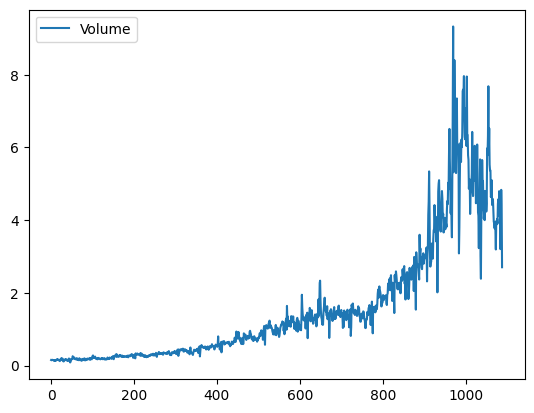

In [4]:
Weekly.plot(y='Volume');

(b) Use the full data set to perform a logistic regression with Direction as the response and the five lag variables plus Volume as predictors. Use the summary function to print the results. Do any of the predictors appear to be statistically significant? If so, which ones?

In [5]:
predictors = Weekly.columns.drop(['Year','Today','Direction'])
design = MS(predictors)
X = design.fit_transform(Weekly)
y = Weekly.Direction == 'Up' # Logistic regression predicts the probability of one event, up / down 

glm = sm.Logit(y,X)
results = glm.fit()
summarize(results)

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


,coef,std err,z,P>|z|
intercept,0.2669,0.086,3.106,0.002
Lag1,-0.0413,0.026,-1.563,0.118
Lag2,0.0584,0.027,2.175,0.030
Lag3,-0.0161,0.027,-0.602,0.547
Lag4,-0.0278,0.026,-1.050,0.294
Lag5,-0.0145,0.026,-0.549,0.583
Volume,-0.0227,0.037,-0.616,0.538


> The smallest p value (<0.05) is for Lag2, where the positive coefficient indicates that if the market had a positive return in the previous 2 weeks the price is expected to go up.

(c) Compute the confusion matrix and overall fraction of correct predictions. Explain what the confusion matrix is telling you about the types of mistakes made by logistic regression.

In [6]:
probs = results.predict()
labels = np.array(['Down']*1089)
labels[probs>0.5] = 'Up'

print("The probability of making a correct decision is {0}".format(round(np.mean(labels == Weekly.Direction),2)))
confusion_table(labels, Weekly.Direction)

The probability of making a correct decision is 0.56


Truth,Down,Up
Predicted,,
Down,54,48
Up,430,557


> From the confusion matrix it is clear that the model is very good at predicting Up direction (92%), but very bad at predicting Down direction (19%). Hence our model has a high false positive rate (81%).

(d) Now fit the logistic regression model using a training data period from 1990 to 2008, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (that is, the data from 2009 and 2010).

In [7]:
# Splitting train-test data
train = (Weekly.Year <= 2008)
Weekly_train = Weekly.loc[train]
Weekly_test = Weekly.loc[~train]
print("The number of rows in training data are {0}".format(Weekly_train.shape[0]))
print("The number of rows in testing data are {0}".format(Weekly_test.shape[0]))

The number of rows in training data are 985
The number of rows in testing data are 104


In [8]:
# Fitting a new model as specified
model = MS(['Lag2']).fit(Weekly)
X_1 = model.transform(Weekly)

X_train, X_test = X_1.loc[train], X_1.loc[~train]
y_train, y_test = y.loc[train], y.loc[~train]
glm_train = sm.Logit(y_train,X_train)

# Making predictions and checking accuracy
results_1 = glm_train.fit()
probs_1 = results_1.predict(exog=X_test)

D = Weekly.Direction 
L_train, L_test = D[train], D[~train]

labels_1 = np.array(['Down']*104)
labels_1[probs_1>0.5]='Up'
print("The probability of making a correct decision is {0}".format(round(np.mean(labels_1==L_test),2)))
confusion_table(labels_1,L_test)

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
The probability of making a correct decision is 0.62


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


(e) Repeat (d) using LDA.

In [9]:
lda = LDA(store_covariance=True)
X_train_d, X_test_d = [M.drop(columns=['intercept']) for M in [X_train, X_test]] # dropping intercepts since LDA adds
lda.fit(X_train_d, L_train)

lda_pred = lda.predict(X_test_d)
print("The probability of making a correct decision is {0}".format(round(np.mean(lda_pred==L_test),2)))
confusion_table(lda_pred,L_test)

The probability of making a correct decision is 0.62


Truth,Down,Up
Predicted,,
Down,9,5
Up,34,56


(f) Repeat (d) using QDA.

In [10]:
qda = QDA(store_covariance=True)
qda.fit(X_train_d, L_train)

qda_pred = qda.predict(X_test_d)
print("The probability of making a correct decision is {0}".format(round(np.mean(qda_pred == L_test),2)))
confusion_table(qda_pred,L_test)

The probability of making a correct decision is 0.59


Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


(g) Repeat (d) using KNN with K = 1.

In [11]:
knn1 = KNeighborsClassifier(n_neighbors=1)
X_train_k, X_test_k = [np.asarray(X) for X in [X_train, X_test]]
knn1.fit(X_train_k, L_train)

knn1_pred = knn1.predict(X_test.values)
print("The probability of making a correct decision is {0}".format(round(np.mean(knn1_pred == L_test),2)))
confusion_table(knn1_pred, L_test)

The probability of making a correct decision is 0.5


Truth,Down,Up
Predicted,,
Down,22,31
Up,21,30


(h) Repeat (d) using naive Bayes.

In [12]:
NB = GaussianNB()
NB.fit(X_train,L_train)

nb_pred = NB.predict(X_test)
print("The probability of making a correct decision is {0}".format(round(np.mean(nb_pred == L_test),2)))
confusion_table(nb_pred, L_test)

The probability of making a correct decision is 0.59


Truth,Down,Up
Predicted,,
Down,0,0
Up,43,61


(i) Which of these methods appears to provide the best results on this data?
>- Logistic regression and Linear Discriminant Analysis give the best results (62% prediction accuracy). This indicates that the decision boundary between Lag2 and Direction (Up) is linear.
>- Hence if the market has made a positive return in the past two weeks, it can be expected to go up.  

(j) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data. Note that you should also experiment with values for K in the KNN classifier.
>- From logistic regression we know that only Lag2 is related to Direction with a statistically significant p value. Additionally, there is a positive correlation b/w Year and Volume. Since our training and test data are in chronological order, it makes sense to include Volume as a predictor.
>- Besides this I don't see how any transformations or interaction terms will help produce a better classification model. Here I expect Logistic Regression and Linear Discriminant analysis to be the better models again. 

In [13]:
# Making the correct X values (y remains same)
model_2 = MS(['Lag2','Volume']).fit(Weekly)
X_2 = model_2.transform(Weekly)
X_2_train, X_2_test = X_2.loc[train], X_2.loc[~train]

# Fitting all the models and making a dictionary of their accuracy 
final_results = {'lr':0,'lda':0,'qda':0,'nb':0,'knn':0}

# Logistic regression 
y_2 = Weekly.Direction == 'Up'
y_2_train = y_2[train]
glm_2 = sm.Logit(y_2_train,X_2_train)
results_lr_2 = glm_2.fit()

probs_lr_2 = results_lr_2.predict(exog=X_2_test)
labels_lr_2 = np.array(['Down']*104)
labels_lr_2[probs_lr_2>0.5] = 'Up'

lr_prob = round(np.mean(labels_lr_2==L_test),2)
final_results['lr'] = lr_prob

# LDA
lda_2 = LDA(store_covariance=True)
X_train_lda2, X_test_lda2 = [M.drop(columns=['intercept']) for M in [X_2_train, X_2_test]]
lda_2.fit(X_train_lda2, L_train)

lda_pred_2 = lda_2.predict(X_test_lda2)

lda_prob = round(np.mean(lda_pred_2==L_test),2)
final_results['lda'] = lda_prob

# QDA 
qda_2 = QDA(store_covariance=True)
qda_2.fit(X_train_lda2, L_train)

qda_pred_2 = qda_2.predict(X_test_lda2)

qda_prob = round(np.mean(qda_pred_2==L_test),2)
final_results['qda'] = qda_prob

# Naive bayes 
NB_2 = GaussianNB()
NB_2.fit(X_2_train,L_train)

nb_pred_2 = NB_2.predict(X_2_test)

nb_prob = round(np.mean(nb_pred_2==L_test),2)
final_results['nb'] = nb_prob

# KNN
X_train_k2, X_test_k2 = [np.asarray(X) for X in [X_2_train, X_2_test]]
values = [1,5,10,25,50]
knn_results = {}
for i in values:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_k2, L_train)
    knn_pred = knn.predict(X_2_test.values)
    knn_prob = round(np.mean(knn_pred==L_test),2)
    knn_results[str(i)] = knn_prob
print("The results for KNN is {0}".format(knn_results))

final_results['knn'] = 0.56
final_results

Optimization terminated successfully.
         Current function value: 0.684972
         Iterations 4
The results for KNN is {'1': 0.56, '5': 0.53, '10': 0.49, '25': 0.56, '50': 0.54}


{'lr': 0.54, 'lda': 0.54, 'qda': 0.47, 'nb': 0.46, 'knn': 0.56}

> We see that K nearest neighbours has the best performance, closely followed by logistic regression and linear discriminant analysis. This maximum is attained for 2 values of k : [1,25]

In [14]:
knn_best = KNeighborsClassifier(n_neighbors=25)
knn_best.fit(X_train_k2, L_train)
knn_best_pred = knn_best.predict(X_2_test.values)
confusion_table(knn_best_pred,L_test)

Truth,Down,Up
Predicted,,
Down,28,31
Up,15,30


>- This model has a false negative rate of 51% and a false positive rate of 35%.
>- Since it is a non-parametric model we cannot make any inferences about the predictors or their effects. Using Volume as an additional predictor lowers the accuracy of our predictions, since with just Lag2 we had 62% classification accuracy. 